In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import box
import pyvista as pv
import gemgis as gg

class observations(object):
    
    ''' This class is the organizational component for stochasitic modeling
    
    
    Parameters:
       data_path (str) : path to working directory (include a trailing '/') e.g "/Users/name/working_directory/"
       init_interfaces (str) : initial interfaces CSV path
       '''
    
    def __init__(self, data_path='./', output_path=None, init_interfaces=None, init_orients=None, output_prefix='No_entry'):
        
        # output parameters
        self.output_path = output_path 
        self.output_prefix = output_prefix
        
        # input parameters
        self.init_interfaces = init_interfaces
        self.init_orients = init_orients
        self.data_path = data_path

        #combining file path and input to use internally in the object
    

        # Load the inital CSV file if they exist
        try:
            if init_interfaces != None:
                self.interfaces_path = self.data_path+self.init_interfaces
                self.interfaces =  pd.read_csv(self.interfaces_path)
            else:
                self.interfaces = pd.DataFrame(None)
        except Exception as e:
            raise ValueError(f"Error reading the interfaces CSV file: {e}")(self.interfaces_path)
        
        try:
            if init_orients != None:
                self.orients_path = self.data_path+self.init_orients
                self.orients =  pd.read_csv(self.orients_path)
            else:
                self.orients = pd.DataFrame(None)
        except Exception as e:
            raise ValueError(f"Error reading the interfaces CSV file: {e}")(self.orients_path)

        self.icols = ['X', 'Y', 'Z','col','row', 'depth', 'depth1', 'depth2']

        self.ocols = ['X','Y','Z','polarity','formation','azimuth','dip']
        


    def show_current_stats(self):

        '''
        Prints output of the current stats
        '''

        print("Oberservations_collected")
        print(f'Output path: {self.output_path}')
        print(f'Output Prefix: {self.output_prefix}')

        print(f"CSV import columns: {self.icols}")
        print("Input interfaces head:")
        print(self.interfaces.head(5))

        
        print(f"CSV import columns: {self.ocols}")
        print("Input orients head:")
        print(self.orients.head(5))

    def update_csv_icols(self, cols):
        
        self.icols = cols
        print(f"CSV import columns: {cols}")
    
    def update_csv_ocols(self, cols):
        
        self.ocols = cols
        print(f"CSV import columns: {cols}")




    # __________ pole to vector and reverse conversion functions _____________
    def dip_azimuth_to_pole_vector(dip, azimuth):
        """
        Converts dip and azimuth to a pole (normal) vector.
        
        Parameters:
            dip (float): Dip angle in degrees (0° to 90°).
            azimuth (float): Azimuth angle in degrees (0° to 360°).
        
        Returns:
            np.ndarray: Pole vector as [x, y, z].
        """
        # Convert angles from degrees to radians
        dip_rad = np.radians(dip)
        azimuth_rad = np.radians(azimuth)
        
        # Compute the components of the pole vector
        x = np.sin(dip_rad) * np.sin(azimuth_rad)
        y = np.sin(dip_rad) * np.cos(azimuth_rad)
        z = np.cos(dip_rad)
        
        return np.array([x, y, z])


    def update_dataframe_with_dip_azimuth(self, df):
        """
        Update a pandas DataFrame by applying the pole_vector_to_dip_azimuth function to three-component vectors.

        Parameters:
            df (pd.DataFrame): Input DataFrame.
            pole_vector_to_dip_azimuth (function): Function that takes [nx, ny, nz] and returns (azimuth, dip).
            nx_col (str): Column name for the x-component.
            ny_col (str): Column name for the y-component.
            nz_col (str): Column name for the z-component.
            azimuth_col (str): Column name to store the azimuth.
            dip_col (str): Column name to store the dip.

        Returns:
            pd.DataFrame: Updated DataFrame with azimuth and dip columns.
        """
        def pole_vector_to_dip_azimuth(pole_vector):
            """
            Converts a pole (X,Y,Z) normal vector to dip and azimuth.
            
            Parameters:
                pole_vector (np.ndarray): Pole vector as [x, y, z].
            
            Returns:
                tuple: (dip in degrees, azimuth in degrees)
            """
            # Normalize the vector to ensure it's a unit vector
            pole_vector = pole_vector / np.linalg.norm(pole_vector)
            x, y, z = pole_vector
            
            # Compute dip angle (inverse cosine of the z component)
            dip = np.degrees(np.arccos(z))
            
            # Compute azimuth (angle in the x-y plane)
            azimuth = np.degrees(np.arctan2(x, y))
            
            # Adjust azimuth to lie between 0° and 360°
            azimuth = azimuth % 360
            
            return azimuth, dip
        
        def compute_azimuth_dip(row):
            # Extract the vector components from the row
            nx, ny, nz = row['nx'], row['ny'], row['nz']
            # Apply the input function
            azimuth_col, dip_col = pole_vector_to_dip_azimuth([nx, ny, nz])
            return pd.Series({azimuth_col:'azimuth', dip_col: 'dip'})

        # Apply the function row-wise and update the DataFrame
        df[['azimuth', 'dip']] = df.apply(compute_azimuth_dip, axis=1)
        print(df.head(10))
        return df

    # ____________ THESE ARE THE ADDING FUNCTIONS _______________

    def add_csv_to_interfaces(self, file_list=[], **kwargs):
        '''
        input [list]: this is a list of files that you want to add
        '''
        _sample_size = kwargs.get('sample_size')
        if _sample_size==None:
            _sample_size=1
    
        for file in file_list:
            print(f"adding: {self.data_path+file}")
            csv_to_add = pd.read_csv(self.data_path+file, names=self.icols)
            #csv_to_add = pd.read_csv(self.data_path+file, sep=' ', names=self.icols, skiprows=np.arange(20))
            self.interfaces = pd.concat((self.interfaces,csv_to_add.sample(frac=_sample_size)))
            

        print(f"Completed adding {len(file_list)} CSV's")

    def add_csv_to_orients(self, file_list=[], **kwargs):
        '''
        input [list]: this is a list of files that you want to add
        '''
        _sample_size = kwargs.get('sample_size')
        if _sample_size==None:
            _sample_size=1
            
    
        for file in file_list:
            csv_to_add = pd.read_csv(self.data_path+file, names=self.ocols)
            self.orients = pd.concat((self.orients,csv_to_add.sample(frac=_sample_size)))
            

        print(f"Completed adding {len(file_list)} CSV's")


    def add_shapefile_to_interfaces(self, file_list, zdepth=None, formation='NOT_ENTERED', azimuth=None, dip=None, **kwargs):



        #Keyword Args assingment
        azimuth_field = kwargs.get('azimuth_field')
        dip_field = kwargs.get('dip_field')
        formation_field = kwargs.get('formation_field')
        z_field = kwargs.get('z_field') 
        X_variance = kwargs.get('xvar')
        Y_variance = kwargs.get('yvar') 
        Z_variance = kwargs.get('zvar') 
        dip_variance = kwargs.get('dipvar') 
        azimuth_variance = kwargs.get('azivar')
        _sample_size = kwargs.get('sample_size')
        if _sample_size==None:
            _sample_size=1
        

        for file in file_list:
            shp_to_add = gpd.read_file(self.data_path+file)
            shape_template = pd.DataFrame(None)
            shape_template['X'] = shp_to_add.geometry.x
            shape_template['Y'] = shp_to_add.geometry.y
            if zdepth==None:
                shape_template['Z'] = shp_to_add.geometry.z
            elif z_field==None:    
                shape_template['Z'] = zdepth
            else:
                shape_template['Z'] = shp_to_add[z_field]
            
            if formation_field != None:
                shape_template['formation'] = shp_to_add[formation_field]
            else:
                shape_template['formation'] = formation
            if azimuth_field != None:
                shape_template['azimuth'] = shp_to_add[azimuth_field]
            else:
                shape_template['azimuth'] = azimuth
            if dip_field != None:
                shape_template['dip'] = shp_to_add[dip_field]
            else:
                shape_template['dip'] = dip

            if X_variance != None:
                shape_template['X_variance'] = X_variance
            else:
                shape_template['X_variance'] = 1

            if Y_variance != None:
                shape_template['Y_variance'] = Y_variance
            else:
                shape_template['Y_variance'] = 1

            if Z_variance != None:
                shape_template['Z_variance'] = Z_variance
            else:
                shape_template['Z_variance'] = 1
            
            if azimuth_variance != None:
                shape_template['azimuth_variance'] = azimuth_variance
            else:
                shape_template['azimuth_variance'] = 1
            
            if dip_variance != None:
                shape_template['dip_variance'] = dip_variance
            else:
                shape_template['dip_variance'] = 1


            shape_template['polarity'] = 1
            #shape_template['azimuth'] = azimuth
            #shape_template['dip'] = dip
            
            self.interfaces = pd.concat((self.interfaces,shape_template.sample(frac=_sample_size)))
        
        print(f"Completed adding {len(file_list)} shapefile(s) to interfaces")
    

    def add_shapefile_to_orients(self, file_list, zdepth=None, formation='NOT_ENTERED', azimuth_field=None, set_azimuth=None, dip=None, **kwargs):


        #Keyword Args assingment
        azimuth_field = kwargs.get('azimuth_field')
        dip_field = kwargs.get('dip_field')
        formation_field = kwargs.get('formation_field')
        X_variance = kwargs.get('xvar')
        Y_variance = kwargs.get('yvar') 
        Z_variance = kwargs.get('zvar') 
        dip_variance = kwargs.get('dipvar') 
        azimuth_variance = kwargs.get('azivar')
        _sample_size = kwargs.get('sample_size')
        if _sample_size==None:
            _sample_size=1
        

        for file in file_list:
            shp_to_add = gpd.read_file(self.data_path+file)
            shape_template = pd.DataFrame(None)
            shape_template['X'] = shp_to_add.geometry.x
            shape_template['Y'] = shp_to_add.geometry.y
            if zdepth==None:
                shape_template['Z'] = shp_to_add.geometry.z
            else:    
                shape_template['Z'] = zdepth
            if formation_field != None:
                shape_template['formation'] = shp_to_add[formation_field]
            else:
                shape_template['formation'] = formation
            if azimuth_field != None:
                shape_template['azimuth'] = shp_to_add[azimuth_field]
            else:
                shape_template['azimuth'] = set_azimuth
            if dip_field != None:
                shape_template['dip'] = shp_to_add[dip_field]
            else:
                shape_template['dip'] = dip

            if X_variance != None:
                shape_template['X_variance'] = X_variance
            else:
                shape_template['X_variance'] = 1

            if Y_variance != None:
                shape_template['Y_variance'] = Y_variance
            else:
                shape_template['Y_variance'] = 1

            if Z_variance != None:
                shape_template['Z_variance'] = Z_variance
            else:
                shape_template['Z_variance'] = 1
            
            if azimuth_variance != None:
                shape_template['azimuth_variance'] = azimuth_variance
            else:
                shape_template['azimuth_variance'] = 1
            
            if dip_variance != None:
                shape_template['dip_variance'] = dip_variance
            else:
                shape_template['dip_variance'] = 1


            shape_template['polarity'] = 1
            #shape_template['azimuth'] = azimuth
            #shape_template['dip'] = dip
            
            self.orients = pd.concat((self.orients,shape_template.sample(frac=_sample_size)))
        
        print(f"Completed adding {len(file_list)} shapefile(s) to orients")


    def sample_surface_from_points(self, points, method='grid', num_points=100, grid_spacing=10):
        """
        Construct a surface from input points, compute normals, and sample points.

        Parameters:
        - points (np.ndarray): Array of shape (N, 3) containing the input points [x, y, z].
        - method (str): Sampling method, either "random" or "grid".
        - num_points (int): Number of random points to sample (used if method is "random").
        - grid_spacing (float): Spacing for regularized grid (used if method is "grid").

        Returns:
        - pd.DataFrame: DataFrame with columns ["x", "y", "z", "nx", "ny", "nz"].
        """
        # Create a PyVista point cloud
        point_cloud = pv.PolyData(points)

        # Create a surface from the point cloud using Delaunay 2D triangulation
        surface = point_cloud.delaunay_2d()

        # Compute normals for the surface
        surface = surface.compute_normals(auto_orient_normals=True, point_normals=True)

        # Extract bounds of the surface
        bounds = surface.bounds  # (xmin, xmax, ymin, ymax, zmin, zmax)
        minx, maxx, miny, maxy, _, _ = bounds

        sampled_points = []

        if method == "random":
        # Generate random points within the bounds
            for _ in range(num_points):
                x, y = np.random.uniform(minx, maxx), np.random.uniform(miny, maxy)
                z = 0  # Assume z = 0 for the surface elevation (or adjust as needed)
                sampled_point_index = surface.find_closest_point((x, y, z))  # Corrected to tuple
                point = surface.points[sampled_point_index]
                normal = surface.point_normals[sampled_point_index]
                sampled_points.append((*point, *normal, 0, 0))

        elif method == "grid":
            # Generate a regular grid of points within the bounds
            x_coords = np.arange(minx, maxx, grid_spacing)
            y_coords = np.arange(miny, maxy, grid_spacing)
            for x in x_coords:
                for y in y_coords:
                    z = 0  # Assume z = 0 for the surface elevation (or adjust as needed)
                    sampled_point_index = surface.find_closest_point((x, y, z))  # Corrected to tuple
                    point = surface.points[sampled_point_index]
                    normal = surface.point_normals[sampled_point_index]
                    sampled_points.append((*point, *normal, 0, 0))
        else:
            raise ValueError("Method must be either 'random' or 'grid'.")

        # Prepare the DataFrame
        df = pd.DataFrame(sampled_points, columns=["X", "Y", "Z", "nx", "ny", "nz", 'azimuth', 'dip'])
        #df = self.update_dataframe_with_dip_azimuth(df)

        def pole_vector_to_dip_azimuth(pole_vector):
            """
            Converts a pole (X,Y,Z) normal vector to dip and azimuth.
            
            Parameters:
                pole_vector (np.ndarray): Pole vector as [x, y, z].
            
            Returns:
                tuple: (dip in degrees, azimuth in degrees)
            """
            
            # Normalize the vector to ensure it's a unit vector
            pole_vector = pole_vector / np.linalg.norm(pole_vector)
            x, y, z = pole_vector
            
            # Compute dip angle (inverse cosine of the z component)
            dip = np.degrees(np.arccos(z))
            
            # Compute azimuth (angle in the x-y plane)
            azimuth = np.degrees(np.arctan2(x, y))
            
            # Adjust azimuth to lie between 0° and 360°
            azimuth = azimuth % 360
            
            return azimuth, dip
        def compute_azimuth_dip(row):
            # Extract the vector components from the row
            nx, ny, nz = row['nx'], row['ny'], row['nz']
            # Apply the input function
            azimuth, dip = pole_vector_to_dip_azimuth([nx, ny, nz])
            return pd.Series({'azimuth': azimuth, 'dip': dip})

        # Apply the function row-wise and update the DataFrame
        df[['azimuth', 'dip']] = df.apply(compute_azimuth_dip, axis=1)
            #nx, ny, nz = row['nx'], row['ny'], row['nz']
                # Apply the input function
        #df['azimuth', 'dip'] = df['nx','ny','nz'].apply(pole_vector_to_dip_azimuth, axis=1)
        return df

    def add_surface_points_to_orients(self, surface, sample_method='grid', num_points=100, grid_spacing=10, **kwargs):
        formation = kwargs.get('formation')
        if formation == None:
            formation = 'NOT_ENTERED'
        frac = kwargs.get('frac')
        if frac ==None:
            frac=1
        if sample_method == 'grid':
            method='grid'
        elif sample_method == 'random':
            method='random'

        num_points=num_points
        grid_spacing=grid_spacing
        gdf = gpd.read_file(surface)
        surf_ = []
        for point in gdf.geometry:
            surf_.append((point.x,point.y,point.z))


        df = self.sample_surface_from_points(surf_, method, num_points, grid_spacing)
        df['formation'] = formation
        self.orients = pd.concat((self.orients,df.sample(frac=frac)))



    def add_surface_points_to_interfaces(self, surface, sample_method='grid', num_points=100, grid_spacing=10, **kwargs):
        formation = kwargs.get('formation')
        if formation == None:
            formation = 'NOT_ENTERED'
        frac = kwargs.get('frac')
        if frac ==None:
            frac=1
        if sample_method == 'grid':
            method='grid'
        elif sample_method == 'random':
            method='random'

        num_points=num_points
        grid_spacing=grid_spacing
        gdf = gpd.read_file(surface)
        surf_ = []
        for point in gdf.geometry:
            surf_.append((point.x,point.y,point.z))
            
        df = self.sample_surface_from_points(surf_, method, num_points, grid_spacing)
        df['formation'] = formation

        self.interfaces = pd.concat((self.interfaces,df.sample(frac=frac)))

    def add_shapefile_linestrings_and_compute_azimuth_to_orients(self, filename, fraction=1, z=0, **kwargs):
        #Keyword Args assingment
        dip = kwargs.get('dip')
        formation = kwargs.get('formation')
        X_variance = kwargs.get('xvar')
        Y_variance = kwargs.get('yvar') 
        Z_variance = kwargs.get('zvar') 
        dip_variance = kwargs.get('dipvar') 
        azimuth_variance = kwargs.get('azivar')
        
        file = self.data_path+filename
        inputgdf = gpd.read_file(file)
        inputgdf['dZ'] = 0
        #print(inputgdf.head(3))
        shape_template = gg.vector.extract_orientations_from_map(gdf=inputgdf)
        shape_template['Z'] = z
        if formation != None:
            df['formation'] = formation
        else:
            shape_template.rename(columns={'Name': 'formation'}, inplace=True)
        if X_variance != None:
            shape_template['X_variance'] = X_variance
        else:
            shape_template['X_variance'] = 1

        if Y_variance != None:
            shape_template['Y_variance'] = Y_variance
        else:
            shape_template['Y_variance'] = 1

        if Z_variance != None:
            shape_template['Z_variance'] = Z_variance
        else:
            shape_template['Z_variance'] = 1
            
        if azimuth_variance != None:
            shape_template['azimuth_variance'] = azimuth_variance
        else:
            shape_template['azimuth_variance'] = 1
            
        if dip_variance != None:
            shape_template['dip_variance'] = dip_variance
        else:
            shape_template['dip_variance'] = 1    
        

        df = pd.DataFrame(shape_template, columns=["X", "Y", "Z", 'formation', 'azimuth', 'dip', 'polarity', 'X_variance', 'Y_variance', 'Z_variance', 'azimuth_variance', 'dip_variance'])

        df['dip'] = dip 
        self.orients = pd.concat((self.orients,df.sample(frac=fraction)))


    def add_shapefile_linestrings_and_compute_azimuth_to_interfaces(self, filename, fraction=1, z=0, **kwargs):
        #Keyword Args assingment
        dip = kwargs.get('dip')
        formation = kwargs.get('formation')
        X_variance = kwargs.get('xvar')
        Y_variance = kwargs.get('yvar') 
        Z_variance = kwargs.get('zvar')
        dip_variance = kwargs.get('dipvar')
        azimuth_variance = kwargs.get('azivar')
        
        file = self.data_path+filename
        inputgdf = gpd.read_file(file)
        inputgdf['dZ'] = 0
        #print(inputgdf.head(3))
        shape_template = gg.vector.extract_orientations_from_map(gdf=inputgdf)
        shape_template['Z'] = z
        if formation != None:
            df['formation'] = formation
        else:
            shape_template.rename(columns={'Name': 'formation'}, inplace=True)
        if X_variance != None:
            shape_template['X_variance'] = X_variance
        else:
            shape_template['X_variance'] = 1

        if Y_variance != None:
            shape_template['Y_variance'] = Y_variance
        else:
            shape_template['Y_variance'] = 1

        if Z_variance != None:
            shape_template['Z_variance'] = Z_variance
        else:
            shape_template['Z_variance'] = 1
            
        if azimuth_variance != None:
            shape_template['azimuth_variance'] = azimuth_variance
        else:
            shape_template['azimuth_variance'] = 1
            
        if dip_variance != None:
            shape_template['dip_variance'] = dip_variance
        else:
            shape_template['dip_variance'] = 1    
        

        df = pd.DataFrame(shape_template, columns=["X", "Y", "Z", 'formation', 'azimuth', 'dip', 'polarity', 'X_variance', 'Y_variance', 'Z_variance', 'azimuth_variance', 'dip_variance'])

        df['dip'] = dip 
        self.interfaces = pd.concat((self.interfaces,df.sample(frac=fraction)))

    # _____________ EXPORTING AND VISUALIZATION FUNCTIONS ________________


    def export_interfaces(self, filename="interfaces.csv"):
        export_path = self.output_path+self.output_prefix+filename
        self.interfaces.to_csv(export_path)
        print(f"completed exporting: {export_path}")

    def export_orientations(self, filename="orients.csv"):
        export_path = self.output_path+self.output_prefix+filename
        self.orients.to_csv(export_path)
        print(f"completed exporting: {export_path}")
    
    def display_3D(self):   #This is not working well yet
        fig, axs = plt.subplots(1, 1, figsize = (12,12), subplot_kw={'projection': '3d'}, sharey=True, sharex=True)
        fig.set_tight_layout(tight="tight")

        axs.scatter(self.orients['X'], self.orients['Y'], self.orients['Z'], color='red', marker='o', s=3, label='Orientations')
        axs.scatter(self.interfaces['X'], self.interfaces['Y'], self.interfaces['Z'], color='blue', marker='.', s=4, label='Interfaces')


    def interfacesDF(self):
        return self.interfaces

    def orientsDF(self):
        return self.orients


In [6]:
import numpy as np
import pandas as pd
import pyvista as pv
#import meshio

def sample_surface_from_points(points, method="random", num_points=100, grid_spacing=10):
    """
    Construct a surface from input points, compute normals, and sample points.

    Parameters:
    - points (np.ndarray): Array of shape (N, 3) containing the input points [x, y, z].
    - method (str): Sampling method, either "random" or "grid".
    - num_points (int): Number of random points to sample (used if method is "random").
    - grid_spacing (float): Spacing for regularized grid (used if method is "grid").

    Returns:
    - pd.DataFrame: DataFrame with columns ["x", "y", "z", "nx", "ny", "nz"].
    """
    # Create a PyVista point cloud
    point_cloud = pv.PolyData(points)

    # Create a surface from the point cloud using Delaunay 2D triangulation
    surface = point_cloud.delaunay_2d()

    # Compute normals for the surface
    surface = surface.compute_normals(auto_orient_normals=True, point_normals=True)

    # Extract bounds of the surface
    bounds = surface.bounds  # (xmin, xmax, ymin, ymax, zmin, zmax)
    minx, maxx, miny, maxy, _, _ = bounds

    sampled_points = []

    if method == "random":
    # Generate random points within the bounds
        for _ in range(num_points):
            x, y = np.random.uniform(minx, maxx), np.random.uniform(miny, maxy)
            z = 0  # Assume z = 0 for the surface elevation (or adjust as needed)
            sampled_point_index = surface.find_closest_point((x, y, z))  # Corrected to tuple
            point = surface.points[sampled_point_index]
            normal = surface.point_normals[sampled_point_index]
            sampled_points.append((*point, *normal))

    elif method == "grid":
        # Generate a regular grid of points within the bounds
        x_coords = np.arange(minx, maxx, grid_spacing)
        y_coords = np.arange(miny, maxy, grid_spacing)
        for x in x_coords:
            for y in y_coords:
                z = 0  # Assume z = 0 for the surface elevation (or adjust as needed)
                sampled_point_index = surface.find_closest_point((x, y, z))  # Corrected to tuple
                point = surface.points[sampled_point_index]
                normal = surface.point_normals[sampled_point_index]
                sampled_points.append((*point, *normal))
    else:
        raise ValueError("Method must be either 'random' or 'grid'.")

    # Prepare the DataFrame
    df = pd.DataFrame(sampled_points, columns=["x", "y", "z", "nx", "ny", "nz"])

    return df

# Example usage
# points = np.random.rand(1000, 3)  # Replace with actual points
# df = sample_surface_from_points(points, method="grid", grid_spacing=10)
# print(df)

In [7]:
test_obs = observations(data_path="/Users/amjonz/Desktop/stocastic_modeling/Californie_Mod_5_surfaces/", output_path='./', init_interfaces=None, init_orients=None, output_prefix='test_entry')

In [8]:
Surf_banjaard_pointer = '/Users/amjonz/Desktop/stocastic_modeling/Californie_Mod_5_surfaces/Top_Banjaard_mod5.shp'
gdf = gpd.read_file(Surf_banjaard_pointer)
surf_ = []
for point in gdf.geometry:
    surf_.append((point.x,point.y,point.z))

#surf_    

df = sample_surface_from_points(surf_, method='random', num_points=100, grid_spacing=1000)

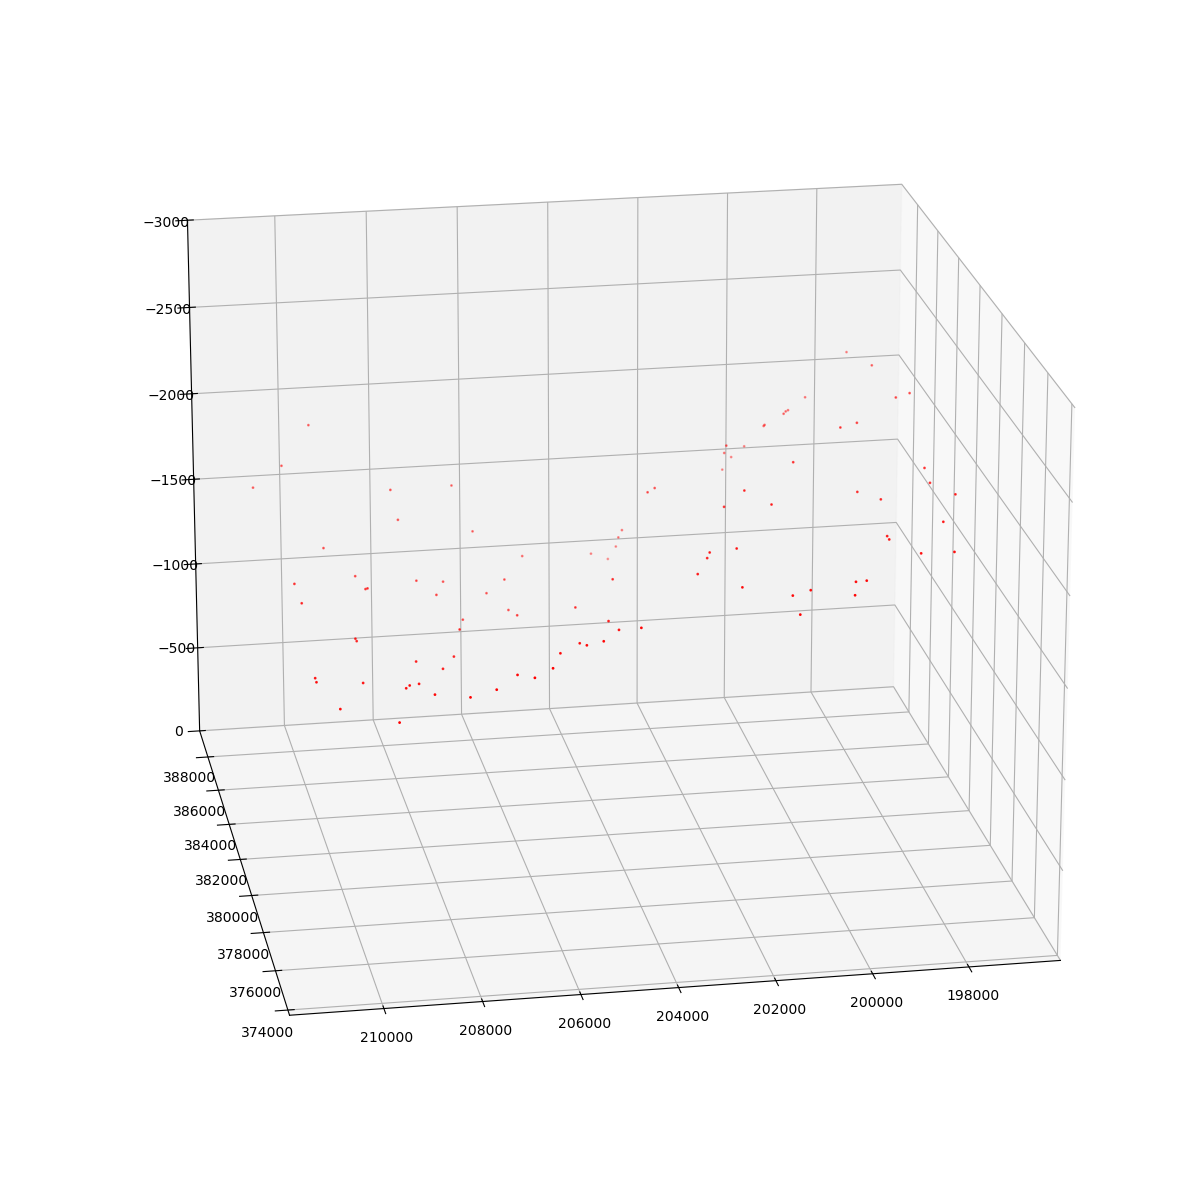

In [9]:
fig, axs = plt.subplots(1, 1, figsize = (12,12), subplot_kw={'projection': '3d'}, sharey=True, sharex=True)
fig.set_tight_layout(tight="tight")
axs.set_zlim(-3000,0)

axs.scatter(df['x'], df['y'], df['z'], color='red', marker='.', s=4, label='NSG')
#axs.scatter(NSGC['X'], NSGC['Y'], NSGC['Z'], color='red', marker='.', s=4, label='NSG')
axs.view_init(elev=200., azim=100)

In [10]:
#
new_cols= ['X','Y','Z','azimuth','dip','polarity','formation','X_variance','Y_variance','Z_variance','dip_variance','azimuth_variance']
test_obs.update_csv_icols(cols=new_cols)
test_obs.update_csv_ocols(cols=new_cols)
test_obs.show_current_stats()

CSV import columns: ['X', 'Y', 'Z', 'azimuth', 'dip', 'polarity', 'formation', 'X_variance', 'Y_variance', 'Z_variance', 'dip_variance', 'azimuth_variance']
CSV import columns: ['X', 'Y', 'Z', 'azimuth', 'dip', 'polarity', 'formation', 'X_variance', 'Y_variance', 'Z_variance', 'dip_variance', 'azimuth_variance']
Oberservations_collected
Output path: ./
Output Prefix: test_entry
CSV import columns: ['X', 'Y', 'Z', 'azimuth', 'dip', 'polarity', 'formation', 'X_variance', 'Y_variance', 'Z_variance', 'dip_variance', 'azimuth_variance']
Input interfaces head:
Empty DataFrame
Columns: []
Index: []
CSV import columns: ['X', 'Y', 'Z', 'azimuth', 'dip', 'polarity', 'formation', 'X_variance', 'Y_variance', 'Z_variance', 'dip_variance', 'azimuth_variance']
Input orients head:
Empty DataFrame
Columns: []
Index: []


In [11]:
test_obs.add_csv_to_interfaces(file_list=['mod5O.csv'], sample_size=.5)

adding: /Users/amjonz/Desktop/stocastic_modeling/Californie_Mod_5_surfaces/mod5O.csv


FileNotFoundError: [Errno 2] No such file or directory: '/Users/amjonz/Desktop/stocastic_modeling/Californie_Mod_5_surfaces/mod5O.csv'

In [12]:
test_obs.show_current_stats()

Oberservations_collected
Output path: ./
Output Prefix: test_entry
CSV import columns: ['X', 'Y', 'Z', 'azimuth', 'dip', 'polarity', 'formation', 'X_variance', 'Y_variance', 'Z_variance', 'dip_variance', 'azimuth_variance']
Input interfaces head:
Empty DataFrame
Columns: []
Index: []
CSV import columns: ['X', 'Y', 'Z', 'azimuth', 'dip', 'polarity', 'formation', 'X_variance', 'Y_variance', 'Z_variance', 'dip_variance', 'azimuth_variance']
Input orients head:
Empty DataFrame
Columns: []
Index: []


In [13]:
test_obs.add_shapefile_to_orients(file_list=["Californie_faults_individual/Viersener_Sprung_exploded_w_azimuth.shp"], zdepth=100, formation_field=None, dip_field='Comment', azimuth_field='azimuth', formation='Viersen', xvar=10,yvar=10,zvar=1,dipvar=9,azivar=10)

ValueError: x attribute access only provided for Point geometries

In [14]:
#testgdf = gpd.read_file("/Users/amjonz/Desktop/stocastic_modeling/Californie_Mod_5_surfaces/Californie_faults_individual/Viersener_Sprung_exploded_w_azimuth.shp",)
#testgdf['dZ'] = 0

#ggtest = gg.vector.extract_orientations_from_map(gdf=testgdf)
#ggtest.head(10)
filename="Californie_faults_individual/Viersener_Sprung_exploded_w_azimuth.shp"
test_obs.add_shapefile_linestrings_and_compute_azimuth_to_orients(filename, fraction=1, z=33, xvar=10)

In [15]:
#dulk = gpd.read_file("/Users/amjonz/Desktop/stocastic_modeling/observations_class/dulkener_surface_trace.shp")
test_obs.show_current_stats()
#test_obs.export_orientations(filename='intface.csv')

Oberservations_collected
Output path: ./
Output Prefix: test_entry
CSV import columns: ['X', 'Y', 'Z', 'azimuth', 'dip', 'polarity', 'formation', 'X_variance', 'Y_variance', 'Z_variance', 'dip_variance', 'azimuth_variance']
Input interfaces head:
Empty DataFrame
Columns: []
Index: []
CSV import columns: ['X', 'Y', 'Z', 'azimuth', 'dip', 'polarity', 'formation', 'X_variance', 'Y_variance', 'Z_variance', 'dip_variance', 'azimuth_variance']
Input orients head:
            X         Y   Z         formation  azimuth   dip  polarity  \
15  279638.03 318731.60  33  Viersener Sprung   316.75  None         1   
210 214920.18 381800.41  33  Viersener Sprung   350.82  None         1   
202 214831.69 379589.24  33  Viersener Sprung   349.91  None         1   
99  237007.78 354253.79  33  Viersener Sprung   290.62  None         1   
111 231403.77 357454.94  33  Viersener Sprung   311.20  None         1   

     X_variance  Y_variance  Z_variance  azimuth_variance  dip_variance  
15           10    

In [17]:
iF = test_obs.orientsDF()
iF

,X,Y,Z,formation,azimuth,dip,polarity,X_variance,Y_variance,Z_variance,azimuth_variance,dip_variance
15,279638.03,318731.60,33,Viersener Sprung,316.75,None,1,10,1,1,1,1
210,214920.18,381800.41,33,Viersener Sprung,350.82,None,1,10,1,1,1,1
202,214831.69,379589.24,33,Viersener Sprung,349.91,None,1,10,1,1,1,1
99,237007.78,354253.79,33,Viersener Sprung,290.62,None,1,10,1,1,1,1
111,231403.77,357454.94,33,Viersener Sprung,311.20,None,1,10,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
148,221921.74,365591.21,33,Viersener Sprung,311.43,None,1,10,1,1,1,1
106,233582.61,355784.55,33,Viersener Sprung,303.85,None,1,10,1,1,1,1
40,271168.95,329767.50,33,Viersener Sprung,331.72,None,1,10,1,1,1,1
21,277875.27,320584.97,33,Viersener Sprung,320.41,None,1,10,1,1,1,1


In [18]:
Surf_banjaard_pointer = '/Users/amjonz/Desktop/stocastic_modeling/Californie_Mod_5_surfaces/Top_Banjaard_mod5.shp'
gdf = gpd.read_file(Surf_banjaard_pointer)
surf_ = []
for point in gdf.geometry:
    surf_.append((point.x,point.y,point.z))

#surf_    
#sample_method = 'grid'
test_obs.add_surface_points_to_orients(Surf_banjaard_pointer, sample_method='grid', num_points=100, grid_spacing=1000, frac=1, formation='Banjaard')
test_obs.show_current_stats()

Oberservations_collected
Output path: ./
Output Prefix: test_entry
CSV import columns: ['X', 'Y', 'Z', 'azimuth', 'dip', 'polarity', 'formation', 'X_variance', 'Y_variance', 'Z_variance', 'dip_variance', 'azimuth_variance']
Input interfaces head:
Empty DataFrame
Columns: []
Index: []
CSV import columns: ['X', 'Y', 'Z', 'azimuth', 'dip', 'polarity', 'formation', 'X_variance', 'Y_variance', 'Z_variance', 'dip_variance', 'azimuth_variance']
Input orients head:
            X         Y     Z         formation  azimuth  dip  polarity  \
15  279638.03 318731.60 33.00  Viersener Sprung   316.75  NaN      1.00   
210 214920.18 381800.41 33.00  Viersener Sprung   350.82  NaN      1.00   
202 214831.69 379589.24 33.00  Viersener Sprung   349.91  NaN      1.00   
99  237007.78 354253.79 33.00  Viersener Sprung   290.62  NaN      1.00   
111 231403.77 357454.94 33.00  Viersener Sprung   311.20  NaN      1.00   

     X_variance  Y_variance  Z_variance  azimuth_variance  dip_variance  nx  \
15      

In [19]:
orientsoutdf = test_obs.orientsDF()

orientsoutdf[orientsoutdf['formation']=='Banjaard']

,X,Y,Z,formation,azimuth,dip,polarity,X_variance,Y_variance,Z_variance,azimuth_variance,dip_variance,nx,ny,nz
61,201045.00,379499.00,-1895.15,Banjaard,297.68,4.80,NaN,NaN,NaN,NaN,NaN,NaN,-0.07,0.04,1.00
154,208045.00,374649.00,-1518.92,Banjaard,246.75,5.83,NaN,NaN,NaN,NaN,NaN,NaN,-0.09,-0.04,0.99
160,207845.00,380599.00,-1251.30,Banjaard,90.80,1.59,NaN,NaN,NaN,NaN,NaN,NaN,0.03,-0.00,1.00
72,201895.00,376749.00,-1860.95,Banjaard,176.63,4.84,NaN,NaN,NaN,NaN,NaN,NaN,0.00,-0.08,1.00
189,209745.00,381499.00,-1318.09,Banjaard,49.01,5.95,NaN,NaN,NaN,NaN,NaN,NaN,0.08,0.07,0.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,208895.00,377649.00,-1356.11,Banjaard,200.19,2.03,NaN,NaN,NaN,NaN,NaN,NaN,-0.01,-0.03,1.00
175,208745.00,381549.00,-1299.62,Banjaard,80.42,9.52,NaN,NaN,NaN,NaN,NaN,NaN,0.16,0.03,0.99
149,206645.00,383849.00,-1095.00,Banjaard,140.69,17.88,NaN,NaN,NaN,NaN,NaN,NaN,0.19,-0.24,0.95
180,209245.00,386149.00,-1637.62,Banjaard,321.82,19.14,NaN,NaN,NaN,NaN,NaN,NaN,-0.20,0.26,0.94


In [20]:
import geopandas as gpd
from shapely.geometry import Point

def gocad_ts_to_point_shapefile(input_ts, output_shapefile):
    """
    Converts a GoCAD *.ts file to a point ESRI shapefile with EPSG:28992 CRS.

    Parameters:
        input_ts (str): Path to the input *.ts file.
        output_shapefile (str): Path to the output shapefile (ends with .shp).
    """
    vertices = []
    
    try:
        # Parse the GoCAD TS file
        with open(input_ts, 'r') as file:
            for line in file:
                line = line.strip()
                if line.startswith("VRTX"):
                    _, idx, x, y, z = line.split(maxsplit=4)
                    vertices.append((int(idx), float(x), float(y), float(z)))

        # Create a GeoDataFrame with point geometries
        points = [Point(v[1], v[2]) for v in vertices]  # X, Y coordinates for each vertex
        z_values = [v[3] for v in vertices]  # Z values (elevation)
        
        gdf = gpd.GeoDataFrame(
            {"Vertex_ID": [v[0] for v in vertices], "Z": z_values, "geometry": points},
            crs="EPSG:28992"
        )

        # Save the GeoDataFrame as an ESRI shapefile
        gdf.to_file(output_shapefile, driver="ESRI Shapefile")

        print(f"Shapefile successfully created at {output_shapefile}")
    except Exception as e:
        print(f"Error: {e}")

# Example usage
#input_ts_path = "example.ts"
#output_shapefile_path = "example_points.shp"
#gocad_ts_to_point_shapefile(input_ts_path, output_shapefile_path)



In [21]:
nsg = '/Users/amjonz/Desktop/stocastic_modeling/CAL_model_7_surf/BOTTOM_NSG_surf.ts'
nsg_out = '/Users/amjonz/Desktop/stocastic_modeling/CAL_model_7_surf/BOTTOM_NSG_surf.shp'
#gocad_ts_to_shapefile(nsg,nsg_out)

In [24]:
nsg_ts = gpd.read_file(nsg_out)
nsg_ts[0,10]

KeyError: (0, 10)

<Axes: >

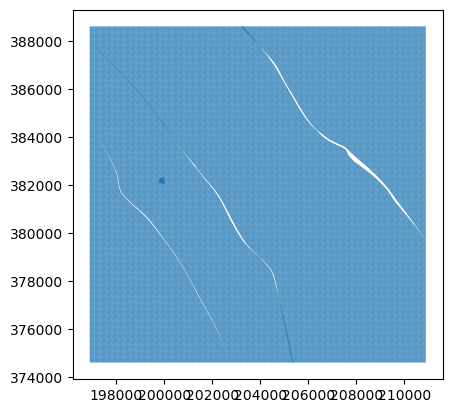

In [25]:
poly = nsg_ts['geometry'].head(1)
nsg_ts.plot()

In [27]:
import numpy as np
import pandas as pd
import pyvista as pv

def load_gocad_ts(file_path):
    """
    Load a Gocad .ts surface file and return points.

    Parameters:
    - file_path (str): Path to the Gocad .ts file.

    Returns:
    - np.ndarray: Array of shape (N, 3) containing the surface points [x, y, z].
    """
    points = []
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('VRTX'):
                _, _, x, y, z = line.split()[:5]
                points.append([float(x), float(y), float(z)])
    return np.array(points)

def sample_surface_from_points(points, method="random", num_points=100, grid_spacing=10):
    """
    Construct a surface from input points, compute normals, and sample points.

    Parameters:
    - points (np.ndarray): Array of shape (N, 3) containing the input points [x, y, z].
    - method (str): Sampling method, either "random" or "grid".
    - num_points (int): Number of random points to sample (used if method is "random").
    - grid_spacing (float): Spacing for regularized grid (used if method is "grid").

    Returns:
    - pd.DataFrame: DataFrame with columns ["x", "y", "z", "nx", "ny", "nz"].
    """
    # Create a PyVista point cloud
    point_cloud = pv.PolyData(points)

    # Create a surface from the point cloud using Delaunay 2D triangulation
    surface = point_cloud.delaunay_2d()

    # Compute normals for the surface
    surface = surface.compute_normals(auto_orient_normals=True, point_normals=True)

    # Extract bounds of the surface
    bounds = surface.bounds  # (xmin, xmax, ymin, ymax, zmin, zmax)
    minx, maxx, miny, maxy, _, _ = bounds

    sampled_points = []

    if method == "random":
        # Generate random points within the bounds
        for _ in range(num_points):
            x, y = np.random.uniform(minx, maxx), np.random.uniform(miny, maxy)
            z = 0  # Assume z = 0 for the surface elevation (or adjust as needed)
            sampled_point_index = surface.find_closest_point((x, y, z))
            point = surface.points[sampled_point_index]
            normal = surface.point_normals[sampled_point_index]
            sampled_points.append((*point, *normal))

    elif method == "grid":
        # Generate a regular grid of points within the bounds
        x_coords = np.arange(minx, maxx, grid_spacing)
        y_coords = np.arange(miny, maxy, grid_spacing)
        for x in x_coords:
            for y in y_coords:
                z = 0  # Assume z = 0 for the surface elevation (or adjust as needed)
                sampled_point_index = surface.find_closest_point((x, y, z))
                point = surface.points[sampled_point_index]
                normal = surface.point_normals[sampled_point_index]
                sampled_points.append((*point, *normal))
    else:
        raise ValueError("Method must be either 'random' or 'grid'.")

    # Prepare the DataFrame
    df = pd.DataFrame(sampled_points, columns=["x", "y", "z", "nx", "ny", "nz"])

    return df

In [28]:
nsg_points = load_gocad_ts(nsg)
df = sample_surface_from_points(nsg_points, method='grid', grid_spacing=300)

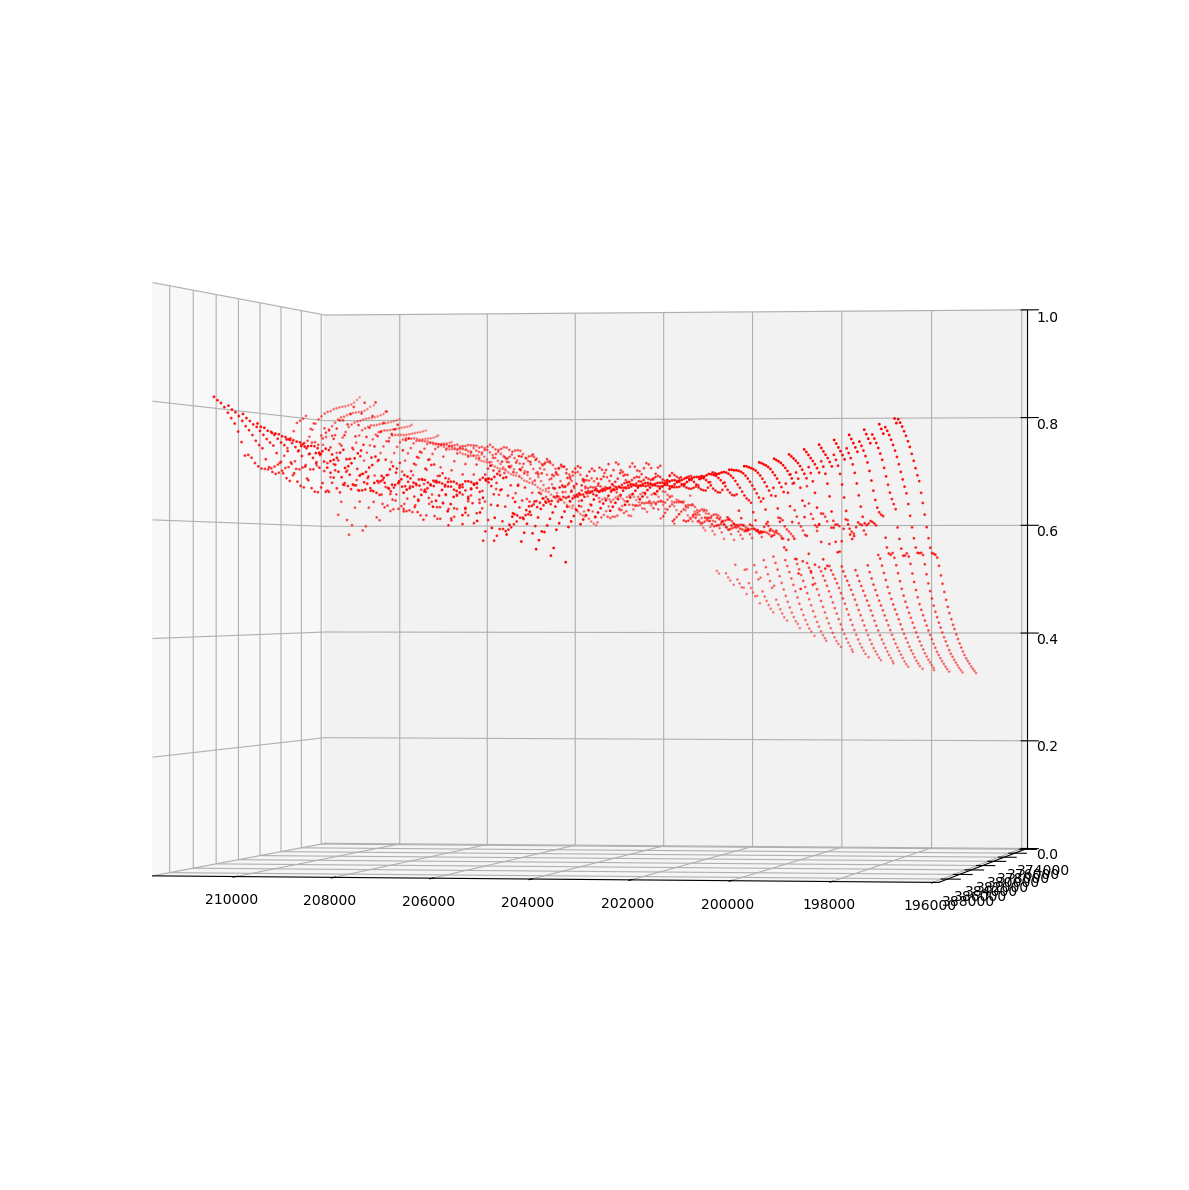

In [29]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 1, figsize = (12,12), subplot_kw={'projection': '3d'}, sharey=True, sharex=True)
fig.set_tight_layout(tight="tight")
axs.set_zlim(0,1)

axs.scatter(df['x'], df['y'], df['z'], color='red', marker='.', s=4, label='NSG')
#axs.scatter(NSGC['X'], NSGC['Y'], NSGC['Z'], color='red', marker='.', s=4, label='NSG')
axs.view_init(elev=0., azim=100)

In [52]:
 def add_surface_points_to_interfaces(surface, sample_method='grid', num_points=100, grid_spacing=10, **kwargs):
        
        #Keyword Args assingment
        interfaces = pd.DataFrame(None)
        formation = kwargs.get('formation')
        if formation == None:
            formation = 'NOT_ENTERED'
        frac = kwargs.get('frac')
        if frac ==None:
            frac=1
        if sample_method == 'grid':
            method='grid'
        elif sample_method == 'random':
            method='random'

        X_variance = kwargs.get('xvar')
        Y_variance = kwargs.get('yvar') 
        Z_variance = kwargs.get('zvar') 
        dip_variance = kwargs.get('dipvar') 
        azimuth_variance = kwargs.get('azivar')  
        

        num_points=num_points
        grid_spacing=grid_spacing
        gdf = gpd.read_file(surface)
        surf_ = []
        for point in gdf.geometry:
            surf_.append((point.x,point.y,point.z))
            
        df = sample_surface_from_points(surf_, method, num_points, grid_spacing)

        
        
        #df = pd.DataFrame(df, columns=["X", "Y", "Z", 'formation', 'azimuth', 'dip', 'polarity', 'X_variance', 'Y_variance', 'Z_variance', 'azimuth_variance', 'dip_variance'])
        if formation != None:
            df['formation'] = formation
        if X_variance != None:
            df['X_variance'] = X_variance
        else:
            df['X_variance'] = 1

        if Y_variance != None:
            df['Y_variance'] = Y_variance
        else:
            df['Y_variance'] = 1

        if Z_variance != None:
            df['Z_variance'] = Z_variance
        else:
            df['Z_variance'] = 1
            
        if azimuth_variance != None:
            df['azimuth_variance'] = azimuth_variance
        else:
            df['azimuth_variance'] = 1
            
        if dip_variance != None:
            df['dip_variance'] = dip_variance
        else:
            df['dip_variance'] = 1

        def pole_vector_to_dip_azimuth(pole_vector):
            """
            Converts a pole (X,Y,Z) normal vector to dip and azimuth.
            
            Parameters:
                pole_vector (np.ndarray): Pole vector as [x, y, z].
            
            Returns:
                tuple: (dip in degrees, azimuth in degrees)
            """
            
            # Normalize the vector to ensure it's a unit vector
            pole_vector = pole_vector / np.linalg.norm(pole_vector)
            x, y, z = pole_vector
            
            # Compute dip angle (inverse cosine of the z component)
            dip = np.degrees(np.arccos(z))
            
            # Compute azimuth (angle in the x-y plane)
            azimuth = np.degrees(np.arctan2(x, y))
            
            # Adjust azimuth to lie between 0° and 360°
            azimuth = azimuth % 360
            
            return azimuth, dip
        def compute_azimuth_dip(row):
            # Extract the vector components from the row
            nx, ny, nz = row['nx'], row['ny'], row['nz']
            # Apply the input function
            azimuth, dip = pole_vector_to_dip_azimuth([nx, ny, nz])
            return pd.Series({'azimuth': azimuth, 'dip': dip})

        # Apply the function row-wise and update the DataFrame
        df[['azimuth', 'dip']] = df.apply(compute_azimuth_dip, axis=1)  

        interfaces = pd.concat((interfaces,df.sample(frac=frac)))

        return interfaces

In [3]:
# Surface points shapefile uncertainty
surface_pnt_xvar = 20
surface_pnt_yvar = 20
surface_pnt_zvar = 70
surface_pnt_dipvar = 10
surface_pnt_azivar = 10

banjaard = '/Users/amjonz/Desktop/stocastic_modeling/CAL_model_7/TOP_Banjaard_surf_pnts.shp'
#cal_mod7.add_surface_points_to_orients(banjaard, sample_method='grid', num_points=100, grid_spacing=500, frac=1, formation='Banjaard',
#                                          xvar=surface_pnt_xvar, yvar=surface_pnt_yvar ,zvar=surface_pnt_zvar, dipvar=surface_pnt_dipvar ,azivar=surface_pnt_azivar)
testdf = add_surface_points_to_interfaces(banjaard, sample_method='grid', num_points=100, grid_spacing=500, frac=1, formation='Banjaard',
                                          xvar=surface_pnt_xvar, yvar=surface_pnt_yvar ,zvar=surface_pnt_zvar, dipvar=surface_pnt_dipvar ,azivar=surface_pnt_azivar)
testdf

NameError: name 'add_surface_points_to_interfaces' is not defined

In [54]:
testdf['azimuth'] = testdf['azimuth']-90
testdf.head(20)

,x,y,z,nx,ny,nz,formation,X_variance,Y_variance,Z_variance,azimuth_variance,dip_variance,azimuth,dip
332,202800.00,386600.00,-1609.10,-0.14,-0.03,0.99,Banjaard,20,20,70,10,10,166.42,8.01
312,202800.00,376600.00,-1818.32,-0.15,-0.07,0.99,Banjaard,20,20,70,10,10,155.52,9.66
653,208400.00,379400.00,-1270.73,0.03,-0.16,0.99,Banjaard,20,20,70,10,10,79.68,9.26
608,206800.00,384400.00,-946.24,-0.54,0.21,0.81,Banjaard,20,20,70,10,10,201.64,35.45
497,205600.00,385000.00,-1169.03,-0.14,0.02,0.99,Banjaard,20,20,70,10,10,187.56,8.16
689,209000.00,383000.00,-1378.67,-0.46,0.07,0.89,Banjaard,20,20,70,10,10,188.99,27.49
309,202400.00,375000.00,-1883.12,0.01,0.01,1.00,Banjaard,20,20,70,10,10,-46.58,0.54
515,206200.00,380200.00,-1335.07,-0.12,-0.07,0.99,Banjaard,20,20,70,10,10,149.57,8.19
424,204600.00,376800.00,-1683.35,-0.08,-0.06,1.00,Banjaard,20,20,70,10,10,141.58,5.55
715,209200.00,381800.00,-1232.49,0.05,0.09,1.00,Banjaard,20,20,70,10,10,-61.94,5.56


In [96]:

def clip_polydata(polydata, xmin, xmax, ymin, ymax, zmin, zmax):
    # Create a box filter for clipping input
    bounds = [xmin, xmax, ymin, ymax, zmin, zmax]
    clipped = polydata.clip_box(bounds=bounds, invert=False)
    return unstructured_to_exact_polydata(clipped)

def unstructured_to_exact_polydata(unstructured_grid):
    """
    Converts a pyvista.UnstructuredGrid surface to a pyvista.PolyData surface
    with the exact same points and lines from the input surface.
    
    Parameters:
    - unstructured_grid (pv.UnstructuredGrid): The input unstructured grid.
    
    Returns:
    - pv.PolyData: The output polydata surface with the same points and lines.
    """
    if not isinstance(unstructured_grid, pv.UnstructuredGrid):
        raise TypeError("Input must be a pyvista.UnstructuredGrid object.")
    
    # Extract points and cells directly
    points = unstructured_grid.points
    cells = unstructured_grid.cells

    # Create PolyData from points and cells
    polydata_surface = pv.PolyData(points, cells)
    
    return polydata_surface

In [118]:
import pyvista as pv
import time

def add_intersection_points(surfaces):
    """
    Add intersection points to each PyVista polydata surface based on intersections
    with other surfaces.

    Parameters:
        surfaces (list of pv.PolyData): List of PyVista PolyData surfaces.

    Returns:
        list of pv.PolyData: List of modified PolyData surfaces with added points.
    """
    if not all(isinstance(surface, pv.PolyData) for surface in surfaces):
        raise ValueError("All inputs must be PyVista PolyData surfaces.")

    modified_surfaces = []

    for i, surface_a in enumerate(surfaces):
        # Create a copy of the current surface to avoid modifying the input
        modified_surface = surface_a.copy()
        print(type(surface_a))
        #time.sleep(2)
        for j, surface_b in enumerate(surfaces):
            if i != j:  # Avoid self-intersection
                # Compute the intersection between surface_a and surface_b
                print(type(surface_b))
                intersection, s1, s2 = surface_a.intersection(surface_b)
                print(type(intersection))
                #time.sleep(2)
                # Check if the intersection has points
                print(intersection.n_points)
                #time.sleep(2)
                if intersection and intersection.n_points > 0:
                    # Add intersection points to the modified surface
                    points_to_add = pv.PolyData(intersection.points)
                    modified_surface = modified_surface.merge(points_to_add)

        modified_surfaces.append(modified_surface.clean(inplace=True).delaunay_2d())

    return modified_surfaces


def add_intersection_points_and_lines(surfaces):
    """
    Add intersection points and line intersections to each PyVista polydata surface
    based on intersections with other surfaces.

    Parameters:
        surfaces (list of pv.PolyData): List of PyVista PolyData surfaces.

    Returns:
        list of pv.PolyData: List of modified PolyData surfaces with added points and line intersections.
    """
    if not all(isinstance(surface, pv.PolyData) for surface in surfaces):
        raise ValueError("All inputs must be PyVista PolyData surfaces.")

    modified_surfaces = []

    for i, surface_a in enumerate(surfaces):
        # Create a copy of the current surface to avoid modifying the input
        modified_surface = surface_a.copy()

        # Extract edges from the surface to look for line intersections
        edges_a = surface_a.extract_edges()

        for j, surface_b in enumerate(surfaces):
            if i != j:  # Avoid self-intersection
                # Compute the intersection between surface_a and surface_b
                intersection, s1, s2  = surface_a.intersection(surface_b)

                # Check if the intersection has points
                if intersection and intersection.n_points > 0:
                    # Add intersection points to the modified surface
                    points_to_add = pv.PolyData(intersection.points)
                    modified_surface = modified_surface.merge(points_to_add)

                # Extract edges from the other surface to look for line intersections
                edges_b = surface_b.extract_edges()

                # Check for line intersections (edges of surface_a with edges of surface_b)
                line_intersections = edges_a.intersection(edges_b)

                # If line intersections exist, add them to the surface
                if line_intersections and line_intersections.n_points > 0:
                    # Add line intersection points to the modified surface
                    points_to_add = pv.PolyData(line_intersections.points)
                    modified_surface = modified_surface.merge(points_to_add)

        modified_surfaces.append(modified_surface)

    return modified_surfaces


# Example usage
if __name__ == "__main__":
    # Create example surfaces (spheres and planes for demonstration)
    #sphere1 = pv.Sphere(center=(0, 0, 0), radius=1.0)
    #sphere2 = pv.Sphere(center=(0.5, 0.5, 0), radius=1.0)
    #plane = pv.Plane(center=(0.25, 0.25, 0), direction=(0, 0, 1), i_size=4, j_size=4)
    #plane.points += 0.4
    boundaries = (198000, 208000, 376000, 384000, -3000, 33)
    xmin, xmax, ymin, ymax, zmin, zmax = boundaries
    extents= (xmin, (xmax-xmin), ymin, (ymax-ymin), zmin, (zmax-zmin))
    surfaces_path = "../cal7_Testrun/" # CAL_Zscore_VTK_surfaces/"
    model_suffix='3'
    zeeland = pv.read(f'{surfaces_path}Zeeland_Cal_mod7_a_{model_suffix}.vtk').delaunay_2d()
    namurian = pv.read(f'{surfaces_path}namurian_Cal_mod7_a_{model_suffix}.vtk').delaunay_2d()
    nsg = pv.read(f'{surfaces_path}NSG_Cal_mod7_a_{model_suffix}.vtk').delaunay_2d()
    tegel = pv.read(f'{surfaces_path}tegel_Cal_mod7_a_{model_suffix}.vtk').delaunay_2d()
    dulky =  pv.read(f'{surfaces_path}dulk_Cal_mod7_a_{model_suffix}.vtk').delaunay_2d()
    belfy =  pv.read(f'{surfaces_path}belf_Cal_mod7_a_{model_suffix}.vtk').delaunay_2d()
    #clip_tegel = clip_polydata(tegel.reconstruct_surface(), xmin, xmax, ymin, ymax, zmin, zmax)
    #clip_dulky = clip_polydata(dulk.reconstruct_surface(), xmin, xmax, ymin, ymax, zmin, zmax)
    #clip_belfy = clip_polydata(belf.reconstruct_surface(), xmin, xmax, ymin, ymax, zmin, zmax)
    clip_zeeland = clip_polydata(zeeland, xmin, xmax, ymin, ymax, zmin, zmax)
    clip_namurian = clip_polydata(namurian, xmin, xmax, ymin, ymax, zmin, zmax)
    clip_NSG = clip_polydata(nsg, xmin, xmax, ymin, ymax, zmin, zmax)
    clip_tegel = clip_polydata(tegel, xmin, xmax, ymin, ymax, zmin, zmax)
    clip_dulky = clip_polydata(dulky, xmin, xmax, ymin, ymax, zmin, zmax)
    clip_belfy = clip_polydata(belfy, xmin, xmax, ymin, ymax, zmin, zmax)


    surface_names = {0:"Zeeland", 1:"Namurian", 2:"NSG", 3:"Belfeld", 4:"Tegelen", 5:"Dulkener"}
    surfaces = [clip_zeeland, clip_namurian, clip_NSG, clip_belfy, clip_tegel, clip_dulky]
   
    
    #surfaces = [zeeland, namurian, nsg, belf, tegel, dulk]

    # Add intersection points to surfaces
    modified_surfaces = add_intersection_points(surfaces)
    #modified_surfaces = add_intersection_points_and_lines(surfaces)
    # Plot original and modified surfaces for comparison
    plotter = pv.Plotter(shape=(2, 1))

    # Plot original surfaces
    plotter.subplot(0, 0)
    plotter.add_text("Original Surfaces")
    for surface in surfaces:
        plotter.add_mesh(surface, opacity=0.5)

    # Plot modified surfaces
    plotter.subplot(1, 0)
    plotter.add_text("Modified Surfaces")
    for modified_surface in modified_surfaces[:1]:
        plotter.add_mesh(modified_surface, opacity=0.2, style='wireframe')
        plotter.add_mesh(modified_surface, opacity=0.2)
    #plotter.add_mesh(plane, opacity=0.1)
    plotter.show()

<class 'pyvista.core.pointset.PolyData'>
<class 'pyvista.core.pointset.PolyData'>
<class 'pyvista.core.pointset.PolyData'>
0
<class 'pyvista.core.pointset.PolyData'>
<class 'pyvista.core.pointset.PolyData'>
0
<class 'pyvista.core.pointset.PolyData'>
<class 'pyvista.core.pointset.PolyData'>
56
<class 'pyvista.core.pointset.PolyData'>
<class 'pyvista.core.pointset.PolyData'>
65
<class 'pyvista.core.pointset.PolyData'>
<class 'pyvista.core.pointset.PolyData'>
6
<class 'pyvista.core.pointset.PolyData'>
<class 'pyvista.core.pointset.PolyData'>
<class 'pyvista.core.pointset.PolyData'>
0
<class 'pyvista.core.pointset.PolyData'>
<class 'pyvista.core.pointset.PolyData'>
16
<class 'pyvista.core.pointset.PolyData'>
<class 'pyvista.core.pointset.PolyData'>
59
<class 'pyvista.core.pointset.PolyData'>
<class 'pyvista.core.pointset.PolyData'>
59
<class 'pyvista.core.pointset.PolyData'>
<class 'pyvista.core.pointset.PolyData'>
12
<class 'pyvista.core.pointset.PolyData'>
<class 'pyvista.core.pointset.P

2025-01-06 13:11:26.239 (329552.286s) [          21A0FA]vtkIntersectionPolyData:2423  WARN|No Intersection between objects 
2025-01-06 13:11:26.240 (329552.287s) [          21A0FA]vtkIntersectionPolyData:2423  WARN|No Intersection between objects 
2025-01-06 13:11:26.288 (329552.335s) [          21A0FA]vtkIntersectionPolyData:2423  WARN|No Intersection between objects 
2025-01-06 13:11:26.340 (329552.387s) [          21A0FA]vtkIntersectionPolyData:2423  WARN|No Intersection between objects 
2025-01-06 13:11:26.442 (329552.489s) [          21A0FA]vtkIntersectionPolyData:2423  WARN|No Intersection between objects 
2025-01-06 13:11:26.442 (329552.490s) [          21A0FA]vtkIntersectionPolyData:2423  WARN|No Intersection between objects 
2025-01-06 13:11:26.505 (329552.552s) [          21A0FA]vtkIntersectionPolyData:2423  WARN|No Intersection between objects 
2025-01-06 13:11:26.505 (329552.553s) [          21A0FA]vtkIntersectionPolyData:2423  WARN|No Intersection between objects 
2025-01-

<class 'pyvista.core.pointset.PolyData'>
59
<class 'pyvista.core.pointset.PolyData'>
<class 'pyvista.core.pointset.PolyData'>
65
<class 'pyvista.core.pointset.PolyData'>
<class 'pyvista.core.pointset.PolyData'>
0
<class 'pyvista.core.pointset.PolyData'>
<class 'pyvista.core.pointset.PolyData'>
0
<class 'pyvista.core.pointset.PolyData'>
<class 'pyvista.core.pointset.PolyData'>
<class 'pyvista.core.pointset.PolyData'>
6
<class 'pyvista.core.pointset.PolyData'>
<class 'pyvista.core.pointset.PolyData'>
12
<class 'pyvista.core.pointset.PolyData'>
<class 'pyvista.core.pointset.PolyData'>
13
<class 'pyvista.core.pointset.PolyData'>
<class 'pyvista.core.pointset.PolyData'>
0
<class 'pyvista.core.pointset.PolyData'>
<class 'pyvista.core.pointset.PolyData'>
0


Widget(value='<iframe src="http://localhost:58317/index.html?ui=P_0x2b50dacc0_48&reconnect=auto" class="pyvist…

In [69]:
import pyvista as pv
import numpy as np
s1 = pv.Sphere(phi_resolution=15, theta_resolution=15)
s2 = s1.copy()
s2.points += np.array([0.25, 0, 0])
intersection, s1_split, s2_split = s1.intersection(s2)
#pl = pv.Plotter()
#_ = pl.add_mesh(s1, style='wireframe')
#_ = pl.add_mesh(s2, style='wireframe')
#_ = pl.add_mesh(intersection, color='r', line_width=10)
#pl.show()

intersection.n_points

106